In [12]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Import libraries

from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import lightgbm as lgb
from sklearn import metrics
import catboost as cb

plt.style.use('fivethirtyeight')

# Set the maximum columns displayed on the screen
pd.set_option("display.max_columns", 150)

## Import data

In [2]:
df_train = pd.read_csv("./Data/training.csv")
df_test = pd.read_csv("./Data/testing.csv")

In [3]:
df_train.head(3)

Unnamed: 0  horse_num          race_id    horse_id  jockey_code  \
0           0          1  200801050610101  2005107051         1031   
1           1          2  200801050610101  2005102028          733   
2           2          3  200801050610101  2005104156          684   

   owner_code  trainer_code  horseweight  carry_weight  SexCD  horse_age  \
0      898009           437        440.0           540      2          3   
1      498800           138        440.0           540      2          3   
2      486800          1054        462.0           540      2          3   

   horse_type  result  horse_win  horse_rank_top3  horse_rank_top8  \
0           1       8          0                0                1   
1           1       1          1                1                1   
2           1       3          0                1                1   

   distance(m)  racetrack_type  turf_condition  dirt_condition  \
0         1200              24               0               1   
1         1200              24               0               1   
2         1200              24               0               1   

   jockey_winrate_top1  jockey_winrate_top3  jockey_winrate_top8  \
0             0.032911             0.122925             0.427567   
1             0.067772             0.218700             0.616844   
2             0.067736             0.214795             0.570410   

   jockey_avg_rank  owner_winrate_top1  owner_winrate_top3  \
0         9.171589        6.497758e-08            0.119403   
1         7.332095        5.900621e-02            0.189441   
2         7.851604        1.106412e-01            0.295119   

   owner_winrate_top8  owner_avg_rank  trainer_winrate_top1  \
0            0.417910        9.059701              0.024168   
1            0.570393        7.726708              0.063216   
2            0.663047        6.741228              0.085256   

   trainer_winrate_top3  trainer_winrate_top8  trainer_avg_rank  \
0              0.104189              0.389366          9.581096   
1              0.209557              0.599801          7.601792   
2              0.254808              0.625000          7.137821   

   recent_avg_rank  
0              8.0  
1              1.0  
2              3.0

### Get data for classification

In [4]:
drop_cols = ["result", "horse_win", "horse_rank_top3", "horse_rank_top8", 
             "jockey_winrate_top1", "owner_winrate_top1", "trainer_winrate_top1",
             "jockey_winrate_top8", "owner_winrate_top8", "trainer_winrate_top8"]
X_train = df_train.iloc[:,7:].drop(drop_cols, axis=1)
y_train_top1 = df_train["horse_win"]
y_train_top3 = df_train["horse_rank_top3"]
y_train_top8 = df_train["horse_rank_top8"]

X_test = df_test.iloc[:,7:].drop(drop_cols, axis=1)
y_test_top1 = df_test["horse_win"]
y_test_top3 = df_test["horse_rank_top3"]
y_test_top8 = df_test["horse_rank_top8"]

## Normalization

In [5]:
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)

## Pair Plot

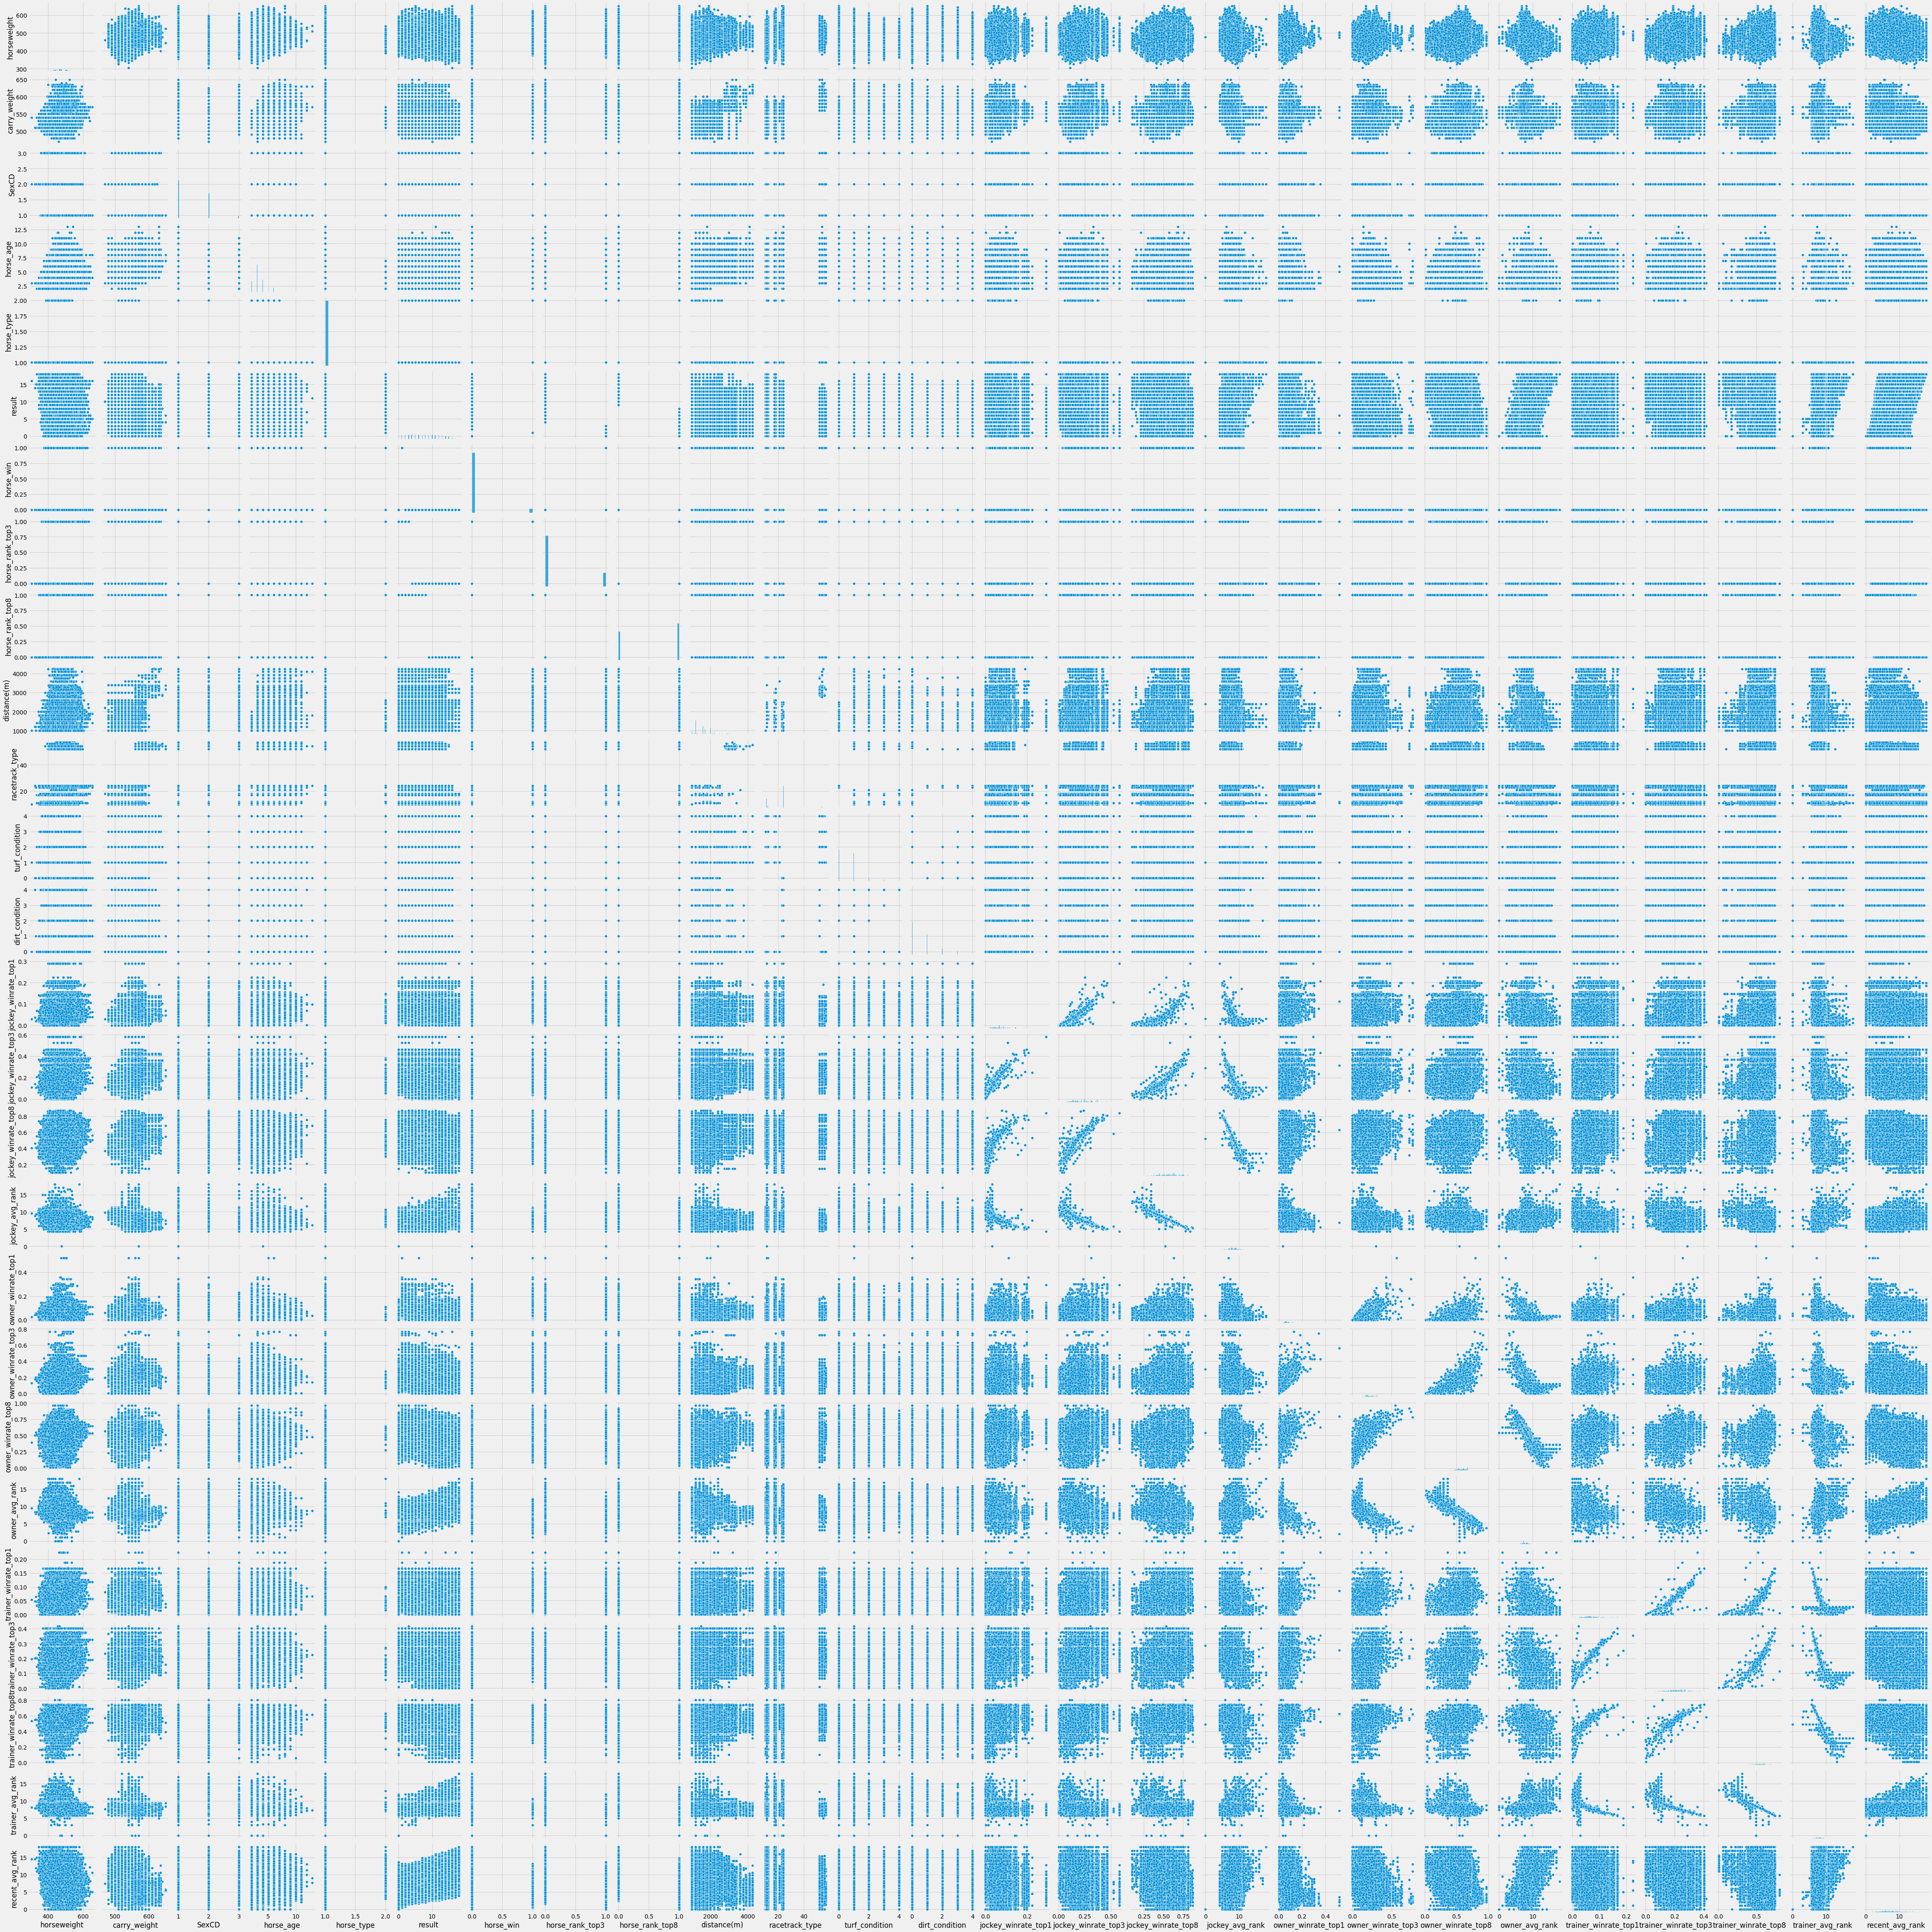

In [39]:
sns.pairplot(df_train.iloc[:,7:])

## Feature selection

### Pearson Correlation

In [6]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in feature_name:
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X_train, y_train_top3, 8)
print(str(len(cor_feature)), 'selected features')
print("selected features: ", cor_feature)

8 selected features
selected features:  ['horseweight', 'trainer_avg_rank', 'trainer_winrate_top3', 'owner_avg_rank', 'owner_winrate_top3', 'jockey_avg_rank', 'jockey_winrate_top3', 'recent_avg_rank']


### SelectFromModel tree-based

In [7]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100))
embeded_rf_selector.fit(X_train, y_train_top3)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_train.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')
print("selected features: ", cor_feature)

6 selected features
selected features:  ['horseweight', 'trainer_avg_rank', 'trainer_winrate_top3', 'owner_avg_rank', 'owner_winrate_top3', 'jockey_avg_rank', 'jockey_winrate_top3', 'recent_avg_rank']


In [8]:
embeded_rf_feature

['horseweight',
 'owner_winrate_top3',
 'owner_avg_rank',
 'trainer_winrate_top3',
 'trainer_avg_rank',
 'recent_avg_rank']

### Chi-squared

In [9]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X_train)
chi_selector = SelectKBest(chi2, k=8)
chi_selector.fit(X_norm, y_train_top3)
chi_support = chi_selector.get_support()
chi_feature = X_train.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')
print("selected features: ", chi_feature)

8 selected features
selected features:  ['SexCD', 'horse_age', 'jockey_winrate_top3', 'jockey_avg_rank', 'owner_winrate_top3', 'owner_avg_rank', 'trainer_winrate_top3', 'recent_avg_rank']


### Recursive Feature Elimination

In [10]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=8, step=15, verbose=5)
rfe_selector.fit(X_norm, y_train_top3)
rfe_support = rfe_selector.get_support()
rfe_feature = X_train.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
print("selected features: ", rfe_feature)

Fitting estimator with 16 features.
8 selected features
selected features:  ['racetrack_type', 'jockey_winrate_top3', 'jockey_avg_rank', 'owner_winrate_top3', 'owner_avg_rank', 'trainer_winrate_top3', 'trainer_avg_rank', 'recent_avg_rank']


### Select features based upon those algorithm and personal analysis

In [5]:
selected_features = ['racetrack_type', 'jockey_winrate_top3', 'jockey_avg_rank',
                     'owner_winrate_top3', 'owner_avg_rank', 'trainer_winrate_top3',
                     'trainer_avg_rank', 'recent_avg_rank', "horseweight",
                     'distance(m)', "horse_age"]

In [6]:
X_train = df_train[selected_features]
y_train_top3 = df_train["horse_rank_top3"]

X_test = df_test[selected_features]
y_test_top3 = df_test["horse_rank_top3"]

In [7]:
# Standard Normalization
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

## Function to plot confusion matrix

In [8]:
def plot_confusion_matrix(predictions, 
                          groundtruth, 
                          class_names,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(groundtruth, predictions)
    
                          
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    cmap = plt.get_cmap('Blues')
    title='Confusion matrix'
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Ground Truth label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.grid(False)
    print("correct_pred_top3/total_actual_top3: ", cm[1,1]/(cm[1,0]+cm[1,1]))
    plt.show()

## Logistic Regression

In [9]:
# Top3
lr_model = linear_model.LogisticRegression()

t0 = time.time()
lr_model.fit(X_train_std, y_train_top3)
t2 = time.time() - t0
print("Training time for top3 logistic regression classifier: ", t2)
predict_top3 = lr_model.predict(X_test_std)
f1_score_model = f1_score(y_test_top3, predict_top3, average="weighted")
print(f"Average f1 score: {f1_score_model:0.5f} \n")

Training time for top3 logistic regression classifier:  1.1019961833953857
Average f1 score: 0.72946 



correct_pred_top3/total_actual_top3:  0.2586483390607102


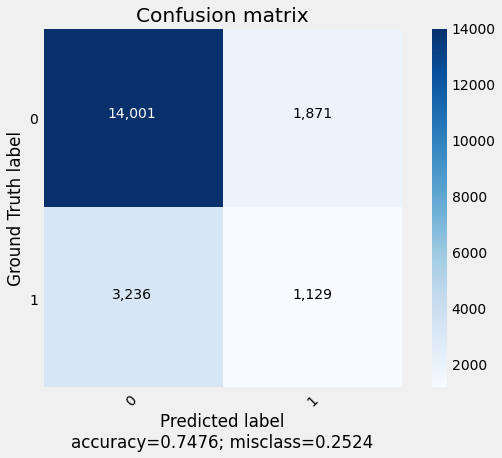

In [22]:
class_names = ['0', '1']
plot_confusion_matrix(predict_top3, y_test_top3, class_names, normalize=False)

## SVM

In [ ]:
# SVM top3
svm_model = svm.SVC(kernel="linear")

t0 = time.time()
svm_model.fit(X_train_std, y_train_top3)
t2 = time.time() - t0
print("Training time for top3 svm classifier: ", t2)
svm_predict_top3 = svm_model.predict(X_test_std)
svm_f1_score = f1_score(y_test_top3, svm_predict_top3, average="weighted")
print(f"Average svm top3 f1_score: {svm_f1_score}")

In [ ]:
class_names = ['True', 'False']
plot_confusion_matrix(svm_predict_top3, y_test_top3, class_names, normalize=False)

## Random Forest

In [30]:
# randomForest top3
rf_model = RandomForestClassifier()

t0 = time.time()
rf_model.fit(X_train_std, y_train_top3)
t3 = time.time() - t0
print("Training time for top3 svm classifier: ", t3)
rf_predict_top3 = rf_model.predict(X_test_std)
rf_f1_score = f1_score(y_test_top3, rf_predict_top3, average="weighted")
print(f"Average random forest top3 f1_score: {rf_f1_score}")

Training time for top3 svm classifier:  96.92756772041321
Average random forest top3 f1_score: 0.7307480924571519


correct_pred_top3/total_actual_top3:  0.2290950744558992


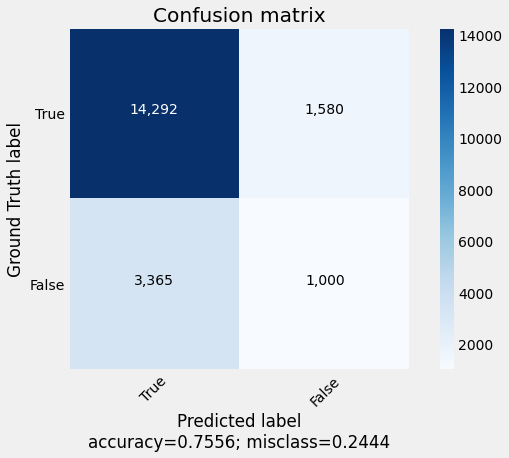

In [31]:
class_names = ['True', 'False']
plot_confusion_matrix(rf_predict_top3, y_test_top3, class_names, normalize=False)

In [28]:
len(y_test_top3[y_test_top3 == 0]) / len(y_test_top3[y_test_top3 == 1])

3.636197021764032

### CatBoost

In [29]:
clf_model = cb.CatBoostClassifier(eval_metric="AUC", depth=10, iterations= 500, 
                                  l2_leaf_reg= 9, learning_rate= 0.15, class_weights = (1, 3.5),
                                  silent=True)

t0 = time.time()
clf_model.fit(X_train_std,y_train_top3)
t4 = time.time() - t0
print("Training time for top3 CatBoost classifier: ", t4)

clf_predict_top3 = clf_model.predict(X_test_std)

# Round the float number
clf_predict_top3 = clf_predict_top3.round(0)
#converting from float to integer
clf_predict_top3 = clf_predict_top3.astype(int)

clf_f1_score = f1_score(y_test_top3, clf_predict_top3, average="weighted")
print(f"Average random forest top3 f1_score: {clf_f1_score}")

Training time for top3 CatBoost classifier:  49.480830669403076
Average random forest top3 f1_score: 0.6941671951085033


correct_pred_top3/total_actual_top3:  0.51340206185567


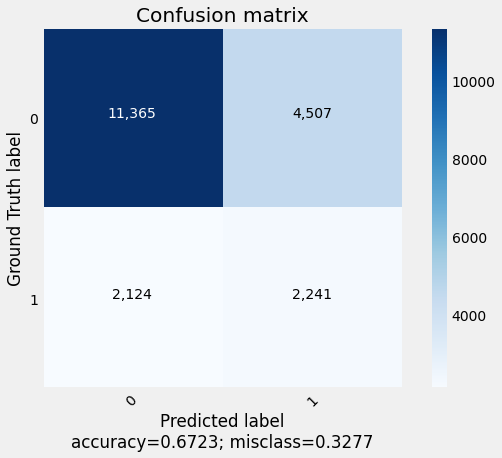

In [30]:
class_names = ['0', '1']
plot_confusion_matrix(clf_predict_top3, y_test_top3, class_names, normalize=False)

### LightGBM

In [18]:
lg_model = lgb.LGBMClassifier(silent=False)

t0 = time.time()
d_train = lgb.Dataset(X_train_std, label=y_train_top3)

params = {"max_depth": 50, "learning_rate" : 0.1, "num_leaves": 300,  "n_estimators": 300,
          'objective': 'binary', "metrics": "auc", "is_unbalance": True}

lg_model = lgb.train(params, d_train)
t5 = time.time() - t0
print("Training time for top3 LightGBM classifier: ", t5)


lg_predict_top3 = lg_model.predict(X_test_std)

# Round the float number
lg_predict_top3 = lg_predict_top3.round(0)
#converting from float to integer
lg_predict_top3 = lg_predict_top3.astype(int)

lg_f1_score = f1_score(y_test_top3, lg_predict_top3, average="weighted")
print(f"Average random forest top3 f1_score: {lg_f1_score}")

[LightGBM] [Info] Number of positive: 108102, number of negative: 392159
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2013
[LightGBM] [Info] Number of data points in the train set: 500261, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216091 -> initscore=-1.288592
[LightGBM] [Info] Start training from score -1.288592
Training time for top3 svm classifier:  5.818581581115723
Average random forest top3 f1_score: 0.694111586553698


In [20]:
confusion_matrix(y_test_top3, lg_predict_top3)

array([[11370,  4502],
       [ 2129,  2236]], dtype=int64)

In [21]:
len(y_test_top3[y_test_top3 == 1])

4365

correct_pred_top3/total_actual_top3:  0.5122565864833906


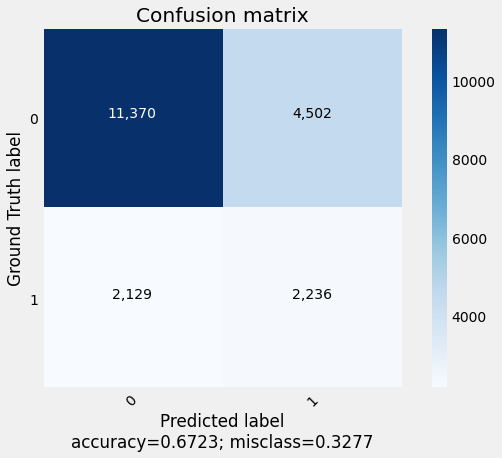

In [23]:
class_names = ['0', '1']
plot_confusion_matrix(lg_predict_top3, y_test_top3, class_names, normalize=False)

In [ ]:
def auc2(m, train, test): 
    return (metrics.roc_auc_score(y_train,m.predict(train)),
                            metrics.roc_auc_score(y_test,m.predict(test)))

lg = lgb.LGBMClassifier(silent=False)
param_dist = {"max_depth": [25,50, 75],
              "learning_rate" : [0.01,0.05,0.1],
              "num_leaves": [300,900,1200],
              "n_estimators": [200]
             }
grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="roc_auc", verbose=5)
grid_search.fit(train,y_train)
grid_search.best_estimator_

d_train = lgb.Dataset(train, label=y_train)
params = {"max_depth": 50, "learning_rate" : 0.1, "num_leaves": 900,  "n_estimators": 300}

# Without Categorical Features
model2 = lgb.train(params, d_train)
auc2(model2, train, test)

#With Catgeorical Features
cate_features_name = ["MONTH","DAY","DAY_OF_WEEK","AIRLINE","DESTINATION_AIRPORT",
                 "ORIGIN_AIRPORT"]
model2 = lgb.train(params, d_train, categorical_feature = cate_features_name)
auc2(model2, train, test)